In [1]:
# Load packages used in this notebook
import os
import json
import numpy as np
import pandas as pd

from cmdstanpy import CmdStanModel, cmdstan_path, install_cmdstan

import arviz as az

import bebi103

import bokeh
from bokeh.io import output_notebook, show

import matplotlib.pyplot as plt

%load_ext pycodestyle_magic

#%pycodestyle_off

/home/mk4139/miniconda3/envs/probprog/lib/python3.9/site-packages/colorcet/__init__.py:82: UserWarning: Trying to register the cmap 'cet_gray' which already exists.
  register_cmap("cet_"+name, cmap=cm[name])
/home/mk4139/miniconda3/envs/probprog/lib/python3.9/site-packages/colorcet/__init__.py:82: UserWarning: Trying to register the cmap 'cet_gray_r' which already exists.
  register_cmap("cet_"+name, cmap=cm[name])
/home/mk4139/miniconda3/envs/probprog/lib/python3.9/site-packages/bebi103/viz.py:38: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  warnings.warn(


# Beyond the Numerical Bayesian Inference Algorithm: Glicko2

Final project for Alp Küçükelbir's Machine Learning Probabilistic Programming (COMS6998) course.

# Introduction


**Model:** Based on "Dynamic paired comparison models with stochastic variances" (http://www.glicko.net/research/dpcmsv.pdf). The model consists of ranking players in a stochastic variance modeling setting similar to, famous statistical model, **GARCH**.

**Goal:** The paper represents a coupling of a model and an approximate Bayesian inference algorithm that marginalizes the model likelihood using the prior distribution of opponents which may result in information loss. In this project, we experiment with the inference algorithms tought in the lecture to investigate if we can improve the ranking algorithm.

**Box's Loop**

![Box's Loop](./boxsloop.png)


## 1. Data

To solve this problem we use a combination of the Lichess API (https://lichess.org/api) and the Deloitte/FIDE Chess Rating Challenge data, which are both publicly available. The FIDE data set consists of 135 months of professional chess game results (win, draw or loss) including more than 1,840,124 games between 14,118 unique players. The Lichess data has many more games readily available as one of the most popular online chess platforms.

## 2. Model

The generative story of the model is as follows:

Draw $\omega^2| 4, 2 \sim InverseGamma(4, 2)$ 

Draw $\tau^2 | 4, 1.5 \sim InverseGamma(4, 1.5)$

For $i \in \{1,2\dots, N\}$:

$\;\;\;\;\;$$\;\;\;\;\;$ Draw player merit variance for $t=0$ $\;$ $\sigma^{2^{(0)}}_i | 4, 2 \sim InverseGamma(4,2) $

$\;\;\;\;\;$$\;\;\;\;\;$ Draw player merit for $t=0$ $\;$ $\gamma_i^{0} | \omega^2 \sim {N}(0, \omega^2)$

For $i \in \{1,2\dots, N\}$:

$\;\;\;\;\;$For $t \in \{1,2, \dots T\}$:

$\;\;\;\;\;$$\;\;\;\;\;$ Draw player merit variance $\;$ $\log \sigma^{2^{(t+1)}}_i | \sigma^{2^{(t)}}_i, \tau^2 \sim \mathcal{N}(\log \sigma^{2^{(t)}}_i, \tau^2) $

$\;\;\;\;\;$$\;\;\;\;\;$ Draw player merit $\;$ $\gamma_i^{(t+1)} | \rho, \sigma^{2^{(t+1)}}_i \sim {N}(\rho \gamma_i^{(t)}, \sigma^{2^{(t+1)}}_i)$

$\;\;\;\;\;$$\;\;\;\;\;$ For $j \in \mathcal{O}_i^{(t)}$:

$\;\;\;\;\;$$\;\;\;\;\;$$\;\;\;\;\;$ Draw score $\;$ $s_{ij}^{(t)} \sim Bernoulli(S(\gamma_i^{(t)} - \gamma_j^{(t)}))$

The model we work is based on a popular Bayesian statistical model called Glicko2, an extension of Glicko model, which is the first Bayesian rating model that models uncertainity of player merits in a time dependent manner. In Glicko2, the latent merit/skills of each player are drawn from a Normal distribution, and the variance of normal distribution are drawn from lognormal distribution. Morover, the probability of winning is modeled by a logistic curve. 

# 3. Inference

We make posterior predictive checks. However, it can be hard making posterior predictive checks in a discrete setting. (write this to critisizm ?)

## 1.Hamiltonian Monte Carlo Markov Chain (HMC)

In this section, we make Bayesian inference by sampling. Specifically, as thought in the class, we sample from the analytically intractable posterior and use them while reasoning about the model. The training procedure and a convergence metric, namely **trace plot** for a parameter $\gamma_{22}$, are as follows:

In [3]:
glicko_stan = './glicko/glicko.stan'
chess_data = './glicko/chess.data.json'

observed_data = json.load(open(chess_data))

glicko_stan = CmdStanModel(
    stan_file=glicko_stan
)

glicko_mcmc = glicko_stan.sample(
    data=chess_data,
    chains=4,
    iter_sampling=1000,
    adapt_delta=0.95,
    seed=123,
)

samples = az.from_cmdstanpy(
    posterior=glicko_mcmc,
    posterior_predictive=["score_pp"],
)

score_pp_mcmc = np.concatenate(
    [
        samples.posterior_predictive["score_pp"][chain] for chain in range(4)
    ]
)

output_notebook()

bokeh.io.show(
    bebi103.viz.trace(
        samples,
        parameters=["gamma[2,2]"]
    )
)

Loading BokehJS ...

![Box's Loop](./trace.jpg)

The trace plots, from 4 **MCMC** chains show a ...

## 2. Mean-Field Variational Inference (VI)

In this section, we use mean-field variational family to approximate the intractavle posterior distribution. The training procedure and a convergence metric, namely **ELBO** by iteration, are as follows:

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


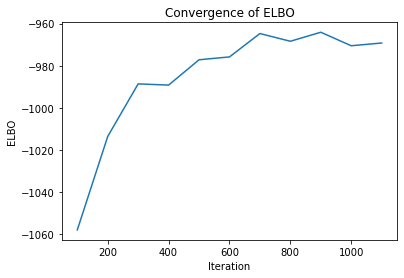

In [6]:
from glicko.plots import plot_elbo

glicko_vi = glicko_stan.variational(
    data=chess_data,
    algorithm="meanfield",
    output_samples=4000,
    grad_samples=5,
)
plot_elbo(glicko_vi)

The **ELBO** converges to a local optimum point, smoothly, as seen at the above figure.

In [13]:
score_pp_vi = get_samples_vi(glicko_vi.variational_sample)

## 3. Maximum a-posteriori Inference (MAP)

In this section, we model the intractable posterior distribution using a Dirac-delta function. This leads to MAP estimate for model parameters:

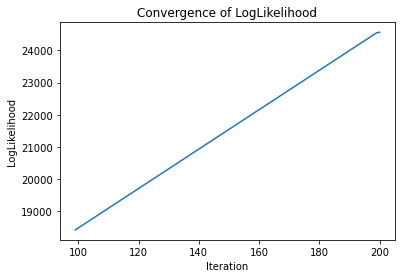

In [94]:
from glicko.plot import plot_likelihood

glicko_map = glicko_stan.optimize(
    data=chess_data,
    algorithm="LBFGS",
    iter=200,
    output_samples=10
)
plot_likelihood(glicko_map)

## 4. Criticism

In this section, we criticize our inference algorithms using posterior predictive checks (PPC). Moving forward, we compare the algorithms with each other using the predictions generated by the posterior predictive distribution.

### 1.Posterior Predictive Checks:

It is hard making posterior predictive checks for Bernoulli distribution. This is because Bernoulli distribution's support is in between $\{0,1\}$, and therefore, test statistics such as minimum and maximum may not be very informative. 

This leads us defining a new random variables for making posterior predictive checks:

1. $X_{total}^{emp}$: Average number of time white player wins throughout all periods.

   $X_{total}^{syn}:$: Average number of time white player wins throughout all periods, predicted by model.
   
   
2. $X_{std}^{emp}$: The standard deviation of white player wins throughout all periods.

   $X_{std}^{syn}:$: The standard deviation of white player wins throughout all periods, predicted by model.
   
   
3. $X_{min}^{emp}$: The minimum of white player wins throughout all periods.

   $X_{min}^{syn}:$: The minimum of white player wins throughout all periods, predicted by model.
   
   
4. $X_{max}^{emp}$: The maximum of white player wins throughout all periods.

   $X_{max}^{syn}:$: The maximum of white player wins throughout all periods, predicted by model.
   
We are interested in $P(T(X_{*}^{synt}) > T(X_{*}^{emp}))$. Where $T$ changes w.r.t. above items. As an example,  $T$ is the function that takes the average over the number of wins throughout the periods for the first case.

**HMC Algorithm:**

Below, we see the posterior predictive checks for the **HMC** algorithm:

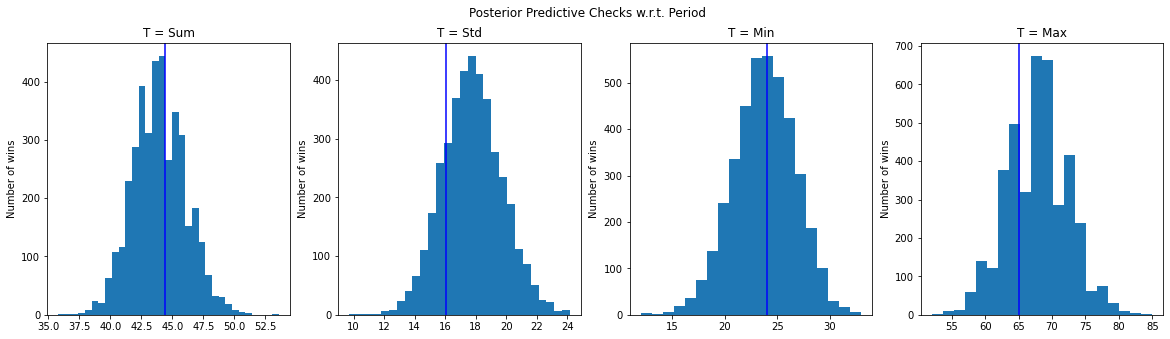

In [10]:
from glicko.plots import plot_ppc

dim = 'period'
check = ['Sum', 'Std', 'Min', 'Max']

plot_ppc(score_pp_mcmc, observed_data, check, dim)

Bayesian p-value concerning each check is computed as:

In [20]:
from glicko.compute import bayesian_p

for (key, value) in bayesian_p(
    score_pp_mcmc, 
    observed_data,
    check, 
    dim
).items():

        print('p-value of {} for {}'.format(
            value,
            key.lower())
             )

p-value of 0.3875 for sum
p-value of 0.8075000000000002 for std
p-value of 0.39525 for min
p-value of 0.6952500000000001 for max


**Mean-field VI Algorithm:**

Below, we see the posterior predictive checks for the **Mean-field VI** algorithm:

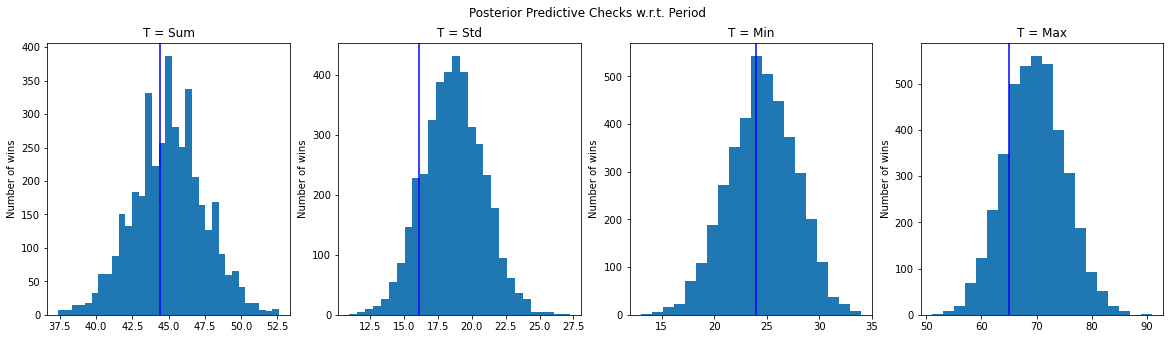

In [14]:
from glicko.plots import plot_ppc

dim = 'period'
check = ['Sum', 'Std', 'Min', 'Max']

plot_ppc(score_pp_vi, observed_data, check, dim)

Bayesian p-value concerning each check is computed as:

In [22]:
from glicko.compute import bayesian_p

for (key, value) in bayesian_p(
    score_pp_vi, 
    observed_data,
    check, 
    dim
).items():

        print('p-value of {} for {}'.format(
            value,
            key.lower())
             )

p-value of 0.5927500000000001 for sum
p-value of 0.8717500000000002 for std
p-value of 0.5017499999999999 for min
p-value of 0.7420000000000002 for max


**MAP Algorithm:**